## Import librairies

In [1]:
%matplotlib notebook

import numpy as np
import scipy
import math
from scipy import sparse, linalg, spatial

from matplotlib import pyplot as plt


from pyunlocbox import functions, solvers
import pandas as pd
import networkx as nx
import random

## Load data

In [2]:
adjacency = np.load('new_adjacency.npy')
n_nodes = np.size(adjacency,1) # the number of nodes in the network
n_edges = sum(sum(adjacency!=0))/2 # number of edges in the network
degrees = sum(adjacency!=0)

In [4]:
# the features of each track the adjacency matrix is based on
features = pd.read_csv('new_out_features.csv')
# track information: id, artist, title, genre
artists_titles = pd.read_csv('artists_titles.csv', )

## Graph computing

In [3]:
G = nx.Graph()
G = nx.from_numpy_matrix(adjacency)

### Layout choice

In [5]:
pos = nx.kamada_kawai_layout(G)
#pos = nx.spring_layout(G)

## Data visualization

C:\Users\vndk36\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


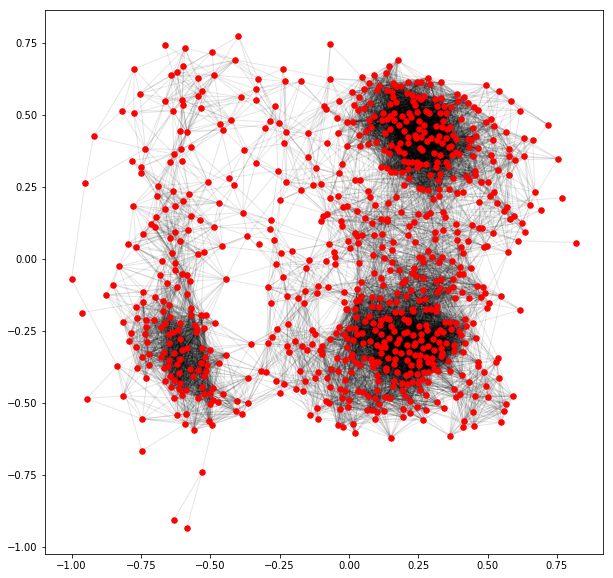

In [6]:
fig1=plt.figure(figsize = (10,10))
nx.draw_networkx_nodes(G, pos, node_size=30)
nx.draw_networkx_edges(G, pos, alpha =0.1)
fig1.savefig('graph.png')

## Node selection

In [7]:
xypos = np.zeros((len(pos),2))

for i in range(0,len(pos)):
    xypos[i][0] = pos[i][0]
    xypos[i][1] = pos[i][1]

In [8]:
class onClick(object):
    def __init__(self, xypos, ax=None, fig =None):
        if ax is None:
            self.ax = plt.gca
        else:
            self.ax = ax
        if fig is None:
            self.fig = plt.gcf
        else:
            self.fig = fig
        self.xy = []
        self.xypos = xypos
        self.clickedPos = []
        self.nbNodes = 2
        self.nbClicks = 0
        self.scats = []
        self.d = []
        self.selectedNodes = []
        self.xplot = []
        self.yplot = []
        
    def __call__(self, event):
        self.nbClicks += 1
        clickX = event.xdata
        clickY = event.ydata
        self.clickedPos.append([clickX, clickY])
        
        if self.nbClicks == 1:
            self.xy = [[clickX, clickY],[clickX, clickY]]
        else:
            self.xy = self.clickedPos[len(self.clickedPos)-self.nbNodes:]
            ax.collections.remove(self.scats[self.nbClicks-2])
            
        self.d = scipy.spatial.distance.cdist(self.xypos, self.xy).transpose()
        self.selectedNodes = np.argmin(self.d, 1)
        
        self.xplot = [self.xypos[self.selectedNodes][0][0], self.xypos[self.selectedNodes][1][0]]
        self.yplot = [self.xypos[self.selectedNodes][0][1], self.xypos[self.selectedNodes][1][1]]
        newScat = ax.scatter(self.xplot, self.yplot)
        self.scats.append(newScat)
        

        
        #ax.collections.remove(self.scats[self.nbClicks-self.nbNodes])
        
        fig.canvas.draw()

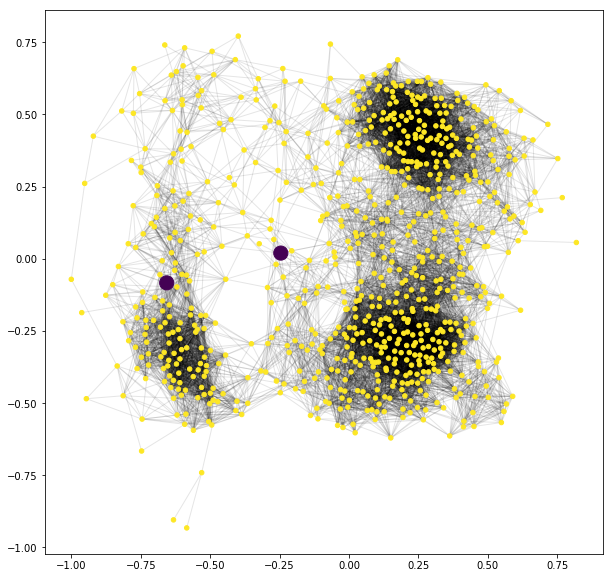

In [9]:
plt.ion()
fig,ax = plt.subplots()
ax.set_title('select nodes')
initScat = ax.scatter(xypos[:, 0],xypos[:, 1])

oc = onClick(xypos, ax=ax)

cid = fig.canvas.mpl_connect('button_press_event', oc)

In [10]:
fig.canvas.mpl_disconnect(cid)

In [19]:
#selected_nodes = [123, 400]

#color = np.ones((n_nodes))
#color[selected_nodes] = 0
#sizes = np.ones((n_nodes))*20
#sizes[selected_nodes] = 200

#plt.figure(figsize = (10,10))
#nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=color)
#nx.draw_networkx_edges(G, pos, alpha =0.1)

selected_nodes = oc.selectedNodes
selected_nodes

array([208, 686], dtype=int64)

## Paths computing

The diameter of the graph gives the minimal length a playlist should have in order to link any pair of tracks in the graph.

In [20]:
nx.diameter(G)

10

In [21]:
# determine the size of the playlist depending on the direct distance between the two nodes
lengths_dependency = [2, 2, 2, 3, 3, 4, 4, 5, 5, 5, 5]
shortcut = len(nx.shortest_path(G, selected_nodes[0], selected_nodes[1]))
max_path_length = lengths_dependency[shortcut]

In [22]:
max_path_length

4

In [23]:
def midpath_point_array(G, source, target, x=5, y=5):
    """Find all midpoints located at distance x from
    the source point and distance y from the target point
        
    midpath_point_array(networkx graph, index of source point,
                        index of target point, distance from source,
                        distance from target)
    """

    source_path_lengths = nx.single_source_dijkstra_path_length(G, source)
    target_path_lengths = nx.single_source_dijkstra_path_length(G, target)

    source_path_lengths_df = pd.DataFrame.from_dict(source_path_lengths, orient='index')\
                        .reset_index()\
                        .rename(columns = {'index':'node', 0:'length'})
    source_path_lengths_df.length = np.ceil(source_path_lengths_df.length)
    #all points at distance x from source
    source_path_lengths_df = source_path_lengths_df[source_path_lengths_df.length == x].drop(columns=['length'])

    target_path_lengths_df = pd.DataFrame.from_dict(target_path_lengths, orient='index')\
                        .reset_index()\
                        .rename(columns = {'index':'node', 0:'length'})
    target_path_lengths_df.length = np.ceil(target_path_lengths_df.length)
    #all points at distance y from target
    target_path_lengths_df = target_path_lengths_df[target_path_lengths_df.length == y].drop(columns=['length'])

    
    common_nodes = pd.merge(source_path_lengths_df, target_path_lengths_df, on='node')
    #midpath nodes is an array of nodes that can be used as a midpoint between start and target
    midpath_nodes = common_nodes.node.values
    return midpath_nodes

In [24]:
midpath_nodes = midpath_point_array(G, selected_nodes[0], selected_nodes[1], max_path_length, max_path_length)

In [25]:
midpath_nodes

array([669, 561, 244, 383,   1, 697, 406,  27], dtype=int64)

In [82]:
#paths = nx.all_simple_paths(G, selected_nodes[0], selected_nodes[1], max_length)
#list_paths = list(paths)
#list_paths
midpath_rd = random.choice(midpath_nodes)

paths_start_mid = nx.all_simple_paths(G, selected_nodes[0], midpath_rd, max_path_length)
paths_mid_target = nx.all_simple_paths(G, midpath_rd, selected_nodes[1], max_path_length)

In [83]:
paths_s2m_array = []
paths_m2t_array = []

print('First set of paths to the midpoint:\n')
for path in paths_start_mid:
    paths_s2m_array.append(path)
    print(path)
print('\n Second set of paths from midpoint to target:\n')
for path in paths_mid_target:
    paths_m2t_array.append(path)
    print(path)

First set of paths to the midpoint:

[123, 724, 251, 114]
[123, 724, 690, 114]

 Second set of paths from midpoint to target:

[114, 251, 349, 400]


## Signal computing

Compute the signal based on weight distribution on the paths

In [ ]:
# get signals

`paths_start_mid` and `paths_mid_target` are generators containing all the possible paths to reach the randomly chosen midpoint from the source or the target points

We need to compute the smoothness on all paths from source to midpoint to keep the smoothest one, do the same to the other half of paths and then join them.
This would give one possible playlist, to be sure to have not the worst one the process should be repeated with other randomly chosen midpoints (not already taken) to compare the smoothness of other possible paths and keep the best one.


## Smoothness

The smoothness of a signal can be computed by the quadratic form

$$ f^\intercal L f = \| \nabla_\mathcal{G} f \|_2^2 = \sum_{i \sim j} W_{ij} (f_j - f_i)^2 $$

In [17]:
import pylab
import math

class AnnoteFinder(object):
    """callback for matplotlib to display an annotation when points are
    clicked on.  The point which is closest to the click and within
    xtol and ytol is identified.
    
    Register this function like this:
    
    scatter(xdata, ydata)
    af = AnnoteFinder(xdata, ydata, annotes)
    connect('button_press_event', af)
    """

    def __init__(self, xdata, ydata, annotes, ax=None, xtol=None, ytol=None):
        self.data = list(zip(xdata, ydata, annotes))
        if xtol is None:
            xtol = ((max(xdata) - min(xdata))/float(len(xdata)))/2
        if ytol is None:
            ytol = ((max(ydata) - min(ydata))/float(len(ydata)))/2
        self.xtol = xtol
        self.ytol = ytol
        if ax is None:
            self.ax = plt.gca()
        else:
            self.ax = ax
        self.drawnAnnotations = {}
        self.links = []

    def distance(self, x1, x2, y1, y2):
        """
        return the distance between two points
        """
        return(math.sqrt((x1 - x2)**2 + (y1 - y2)**2))

    def __call__(self, event):

        if event.inaxes:

            clickX = event.xdata
            clickY = event.ydata
            if (self.ax is None) or (self.ax is event.inaxes):
                annotes = []
                # print(event.xdata, event.ydata)
                for x, y, a in self.data:
                    # print(x, y, a)
                    if ((clickX-self.xtol < x < clickX+self.xtol) and
                            (clickY-self.ytol < y < clickY+self.ytol)):
                        annotes.append(
                            (self.distance(x, clickX, y, clickY), x, y, a))
                if annotes:
                    annotes.sort()
                    distance, x, y, annote = annotes[0]
                    self.drawAnnote(event.inaxes, x, y, annote)
                    for l in self.links:
                        l.drawSpecificAnnote(annote)

    def drawAnnote(self, ax, x, y, annote):
        """
        Draw the annotation on the plot
        """
        if (x, y) in self.drawnAnnotations:
            markers = self.drawnAnnotations[(x, y)]
            for m in markers:
                m.set_visible(not m.get_visible())
            self.ax.figure.canvas.draw_idle()
        else:
            t = ax.text(x, y, " - %s" % (annote),)
            m = ax.scatter([x], [y], marker='d', c='r', zorder=100)
            self.drawnAnnotations[(x, y)] = (t, m)
            self.ax.figure.canvas.draw_idle()

    def drawSpecificAnnote(self, annote):
        annotesToDraw = [(x, y, a) for x, y, a in self.data if a == annote]
        for x, y, a in annotesToDraw:
            self.drawAnnote(self.ax, x, y, a)

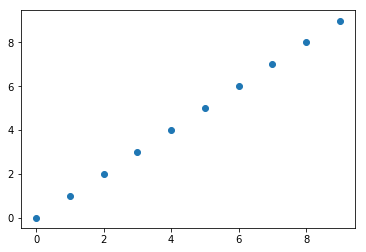

In [18]:
plt.ion()
fig,ax = plt.subplots()
initScat = ax.scatter(xypos[:, 0],xypos[:, 1])

oc = onClick(xypos, ax=ax)

cid = fig.canvas.mpl_connect('button_press_event', oc)

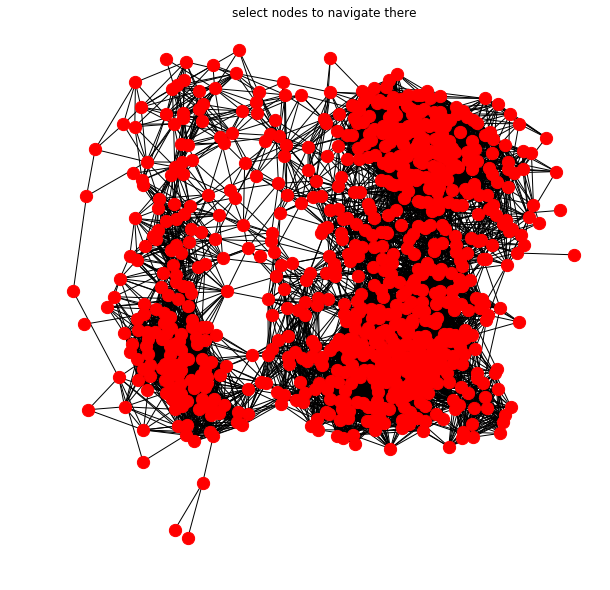

In [19]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_title('select nodes to navigate there')

x,y,annotes=[],[],[]

for key in pos:
    d=pos[key]
    annotes.append(key)
    x.append(d[0])
    y.append(d[1])

nx.draw(G,pos,font_size=8,node_size=150)

af = AnnoteFinder(x,y, annotes)
fig.canvas.mpl_connect('button_press_event', af)

plt.show()

In [233]:
signal = np.random.rand(2, n_nodes)
signal

array([[0.53542667, 0.53668105, 0.56839337, ..., 0.03688969, 0.26394309,
        0.43031755],
       [0.82579672, 0.60590044, 0.46838335, ..., 0.35350168, 0.25063108,
        0.57801094]])

In [234]:
def compute_smoothness(source_to_mid_path, mid_to_target_path, signals):
    
    nb_signals = np.size(signals, 0)
    nb_paths_s2m = np.size(source_to_mid_path, 0)
    nb_paths_m2t = np.size(mid_to_target_path, 0)
    nb_nodes_path = np.size(source_to_mid_path, 1)
    paths_s2m_smoothness = np.zeros([nb_signals, nb_paths_s2m])
    paths_m2t_smoothness = np.zeros([nb_signals, nb_paths_m2t])
    
    for signal_index in range(0, nb_signals):
        signal = signals[signal_index]
        for path_s2m_index in range(0, nb_paths_s2m):
            path = source_to_mid_path[path_s2m_index]
            for node_index in range(0, nb_nodes_path-1):
                nodes = [path[node_index], path[node_index+1]]
                smoothness = adjacency[nodes[0], nodes[1]]*np.power(signal[nodes[1]]-signal[nodes[0]] ,2)
                paths_s2m_smoothness[signal_index, path_s2m_index] += smoothness
    
        for path_m2t_index in range(0, nb_paths_m2t):
            path = mid_to_target_path[path_m2t_index]
            for node_index in range(0, nb_nodes_path-1):
                nodes = [path[node_index], path[node_index+1]]
                smoothness = adjacency[nodes[0], nodes[1]]*np.power(signal[nodes[1]]-signal[nodes[0]] ,2)
                paths_m2t_smoothness[signal_index, path_m2t_index] += smoothness
    
    return paths_s2m_smoothness, paths_m2t_smoothness

In [235]:
s2m_smoothness, m2t_smoothness = compute_smoothness(paths_s2m_array, paths_m2t_array, signal)

In [236]:
def find_path_lowest_smoothness(source_to_mid_path, mid_to_target_path, signal):
    
    nb_signals = np.size(signal, 0)
    nb_paths_s2m = np.size(source_to_mid_path, 0)
    nb_paths_m2t = np.size(mid_to_target_path, 0)
    nb_nodes_path = np.size(source_to_mid_path, 1)
    all_signals_smoothness_s2m = np.zeros([1, nb_paths_s2m])
    all_signals_smoothness_m2t = np.zeros([1, nb_paths_m2t])
    
    s2m_smoothness_signals, m2t_smoothness_signals = compute_smoothness(source_to_mid_path, mid_to_target_path, signal)
    
    for signal_index in range(0, nb_signals):
        all_signals_smoothness_s2m += s2m_smoothness_signals[signal_index]
        all_signals_smoothness_m2t += m2t_smoothness_signals[signal_index]
        
    min_smoothness_s2m_id = np.argmin(all_signals_smoothness_s2m)
    min_smoothness_m2t_id = np.argmin(all_signals_smoothness_m2t)
    
    final_s2m_path = source_to_mid_path[min_smoothness_s2m_id]
    final_m2t_path = mid_to_target_path[min_smoothness_m2t_id]
    
    final_smoothness_s2m = all_signals_smoothness_s2m[0][min_smoothness_s2m_id]
    final_smoothness_m2t = all_signals_smoothness_m2t[0][min_smoothness_m2t_id]
    final_smoothness = np.concatenate((final_smoothness_s2m, final_smoothness_m2t), axis=None)
    
    return final_s2m_path, final_m2t_path, final_smoothness

In [237]:
s2m_path, m2t_path, smoothness = find_path_lowest_smoothness(paths_s2m_array, paths_m2t_array, signal)

<IPython.core.display.Javascript object>


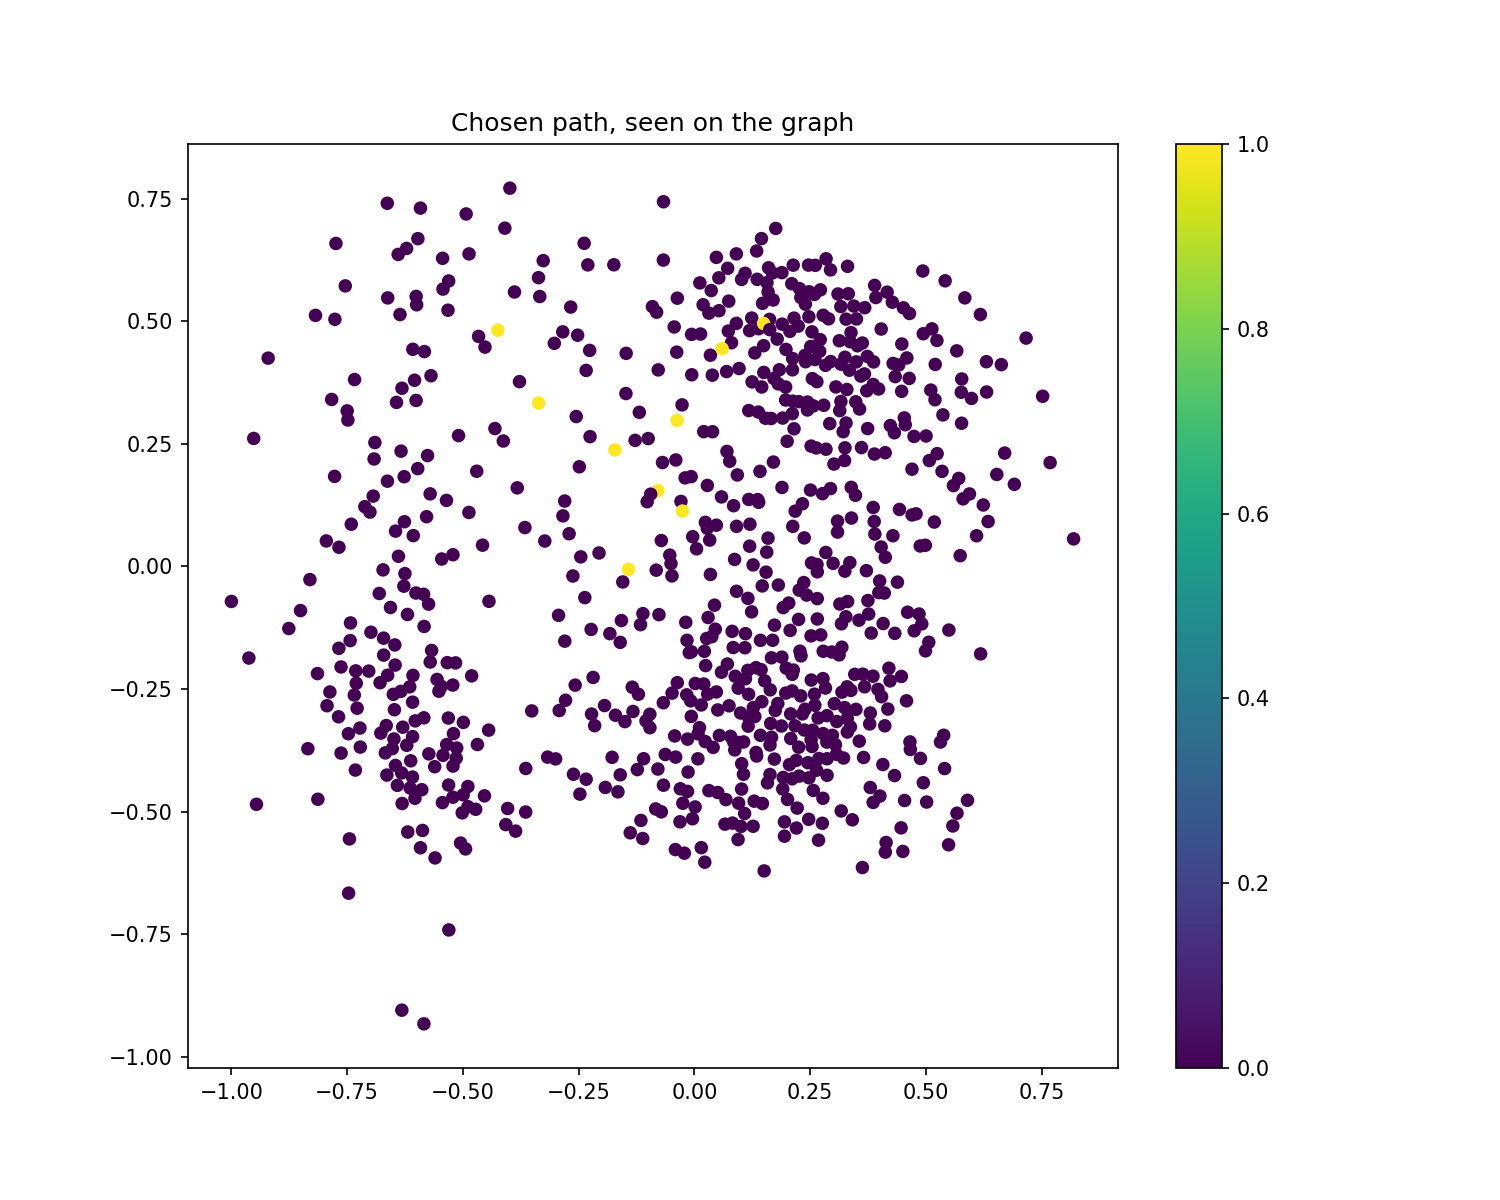

Text(0.5,1,'Chosen path, seen on the graph')

In [238]:
selected_path_nodes = np.zeros([n_nodes])
selected_path_nodes[np.concatenate((s2m_path, m2t_path), axis=None)] = 1

fig = plt.figure(figsize = (10, 8))
im = nx.draw_networkx_nodes(G, pos, node_size=30, node_color=selected_path_nodes)

plt.colorbar(im)
plt.title('Chosen path, seen on the graph')

## Playlist generation

In [20]:
def playlist_from_paths(source_to_mid_path, mid_to_target_path):
    
    playlist_track_id = pd.DataFrame(source_to_mid_path + mid_to_target_path[1:len(mid_to_target_path)],\
                                     columns=['node_index'])
    playlist = playlist_track_id.merge(artists_titles, left_on='node_index', right_index=True)
    # uncomment next line for the simplified version
    #playlist = playlist[['artist', 'title']] 
    return playlist

In [21]:
# using for example path1 and path2 as the half-paths chosen before
playlist_from_paths(s2m_path, m2t_path)

,node_index,track_id,artist,title,genre
0,208,4838,Peelander-Z,Punk Rock,Rock
1,205,4835,Peelander-Z,Steak,Rock
2,243,14734,Throwing Muses,Shark,Rock
3,351,40986,The Corin Tucker Band,Doubt,Rock
4,561,14652,Animal Style,DMG Guitar,Electronic
5,373,47478,Higgins,Yes I Know,Rock
6,184,3840,Lightning Bolt,Track 08,Rock
7,98,13197,First,Different Day,Pop
8,686,47072,Eric Skiff,Come and Find Me,Electronic
